**Imports**

In [2]:
!pip install skforecast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
import warnings
warnings.filterwarnings("ignore")

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#skforecast stuff
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Prophet Predictions**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/394_points.csv', usecols=[0,11], index_col=[0], parse_dates=[0])
data.head()

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570


In [4]:
data = data.reset_index().rename(columns = {'timestamp':'ds'})
data = data.rename(columns={data.columns[1]:'y'})
data.head()

,ds,y
0,2018-01-01 05:00:00,0.660
1,2018-01-01 06:00:00,0.660
2,2018-01-01 07:00:00,0.615
3,2018-01-01 08:00:00,0.570
4,2018-01-01 09:00:00,0.570


In [5]:
data['y'] = np.log(data['y'])
data.head()

,ds,y
0,2018-01-01 05:00:00,-0.415515
1,2018-01-01 06:00:00,-0.415515
2,2018-01-01 07:00:00,-0.486133
3,2018-01-01 08:00:00,-0.562119
4,2018-01-01 09:00:00,-0.562119


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/ce4mina4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/3_klnvud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27894', 'data', 'file=/tmp/tmpsobbnafk/ce4mina4.json', 'init=/tmp/tmpsobbnafk/3_klnvud.json', 'output', 'file=/tmp/tmpsobbnafk/prophet_model9h5ow5gs/prophet_model-20230823135551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:55:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:55:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


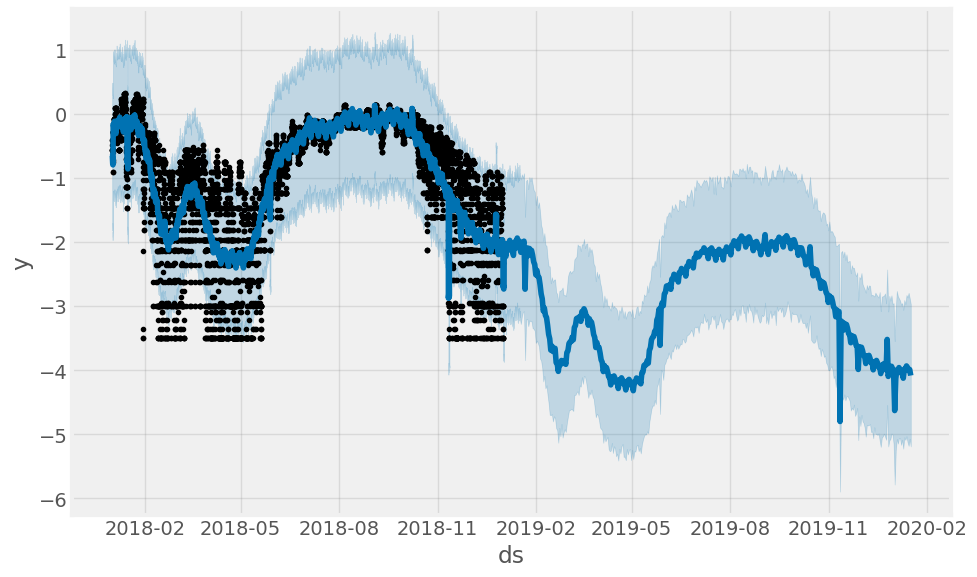

In [6]:
m = Prophet(changepoint_prior_scale=0.011,yearly_seasonality=True,interval_width=0.95)
m.add_country_holidays(country_name='US')
m.fit(data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)

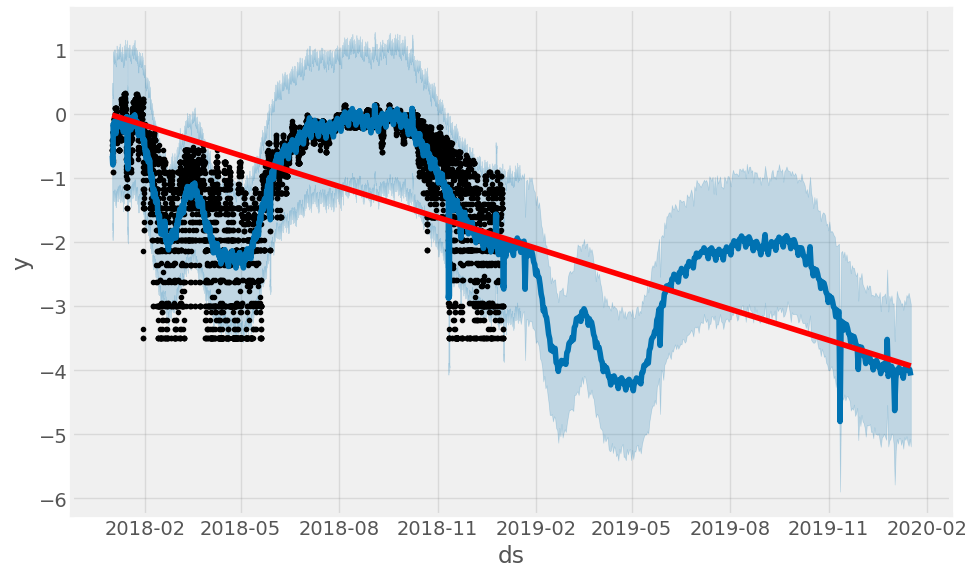

In [7]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [8]:
df = pd.read_csv('/content/drive/MyDrive/394_points.csv', usecols=[0,11], index_col=[0], parse_dates=[0])
df.head()

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570


In [9]:
df = df.rename(columns={df.columns[0]:'y'})
df.head()

,y
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570


In [10]:
df['y'] = np.log(df['y'])
df.head()

,y
timestamp,
2018-01-01 05:00:00,-0.415515
2018-01-01 06:00:00,-0.415515
2018-01-01 07:00:00,-0.486133
2018-01-01 08:00:00,-0.562119
2018-01-01 09:00:00,-0.562119


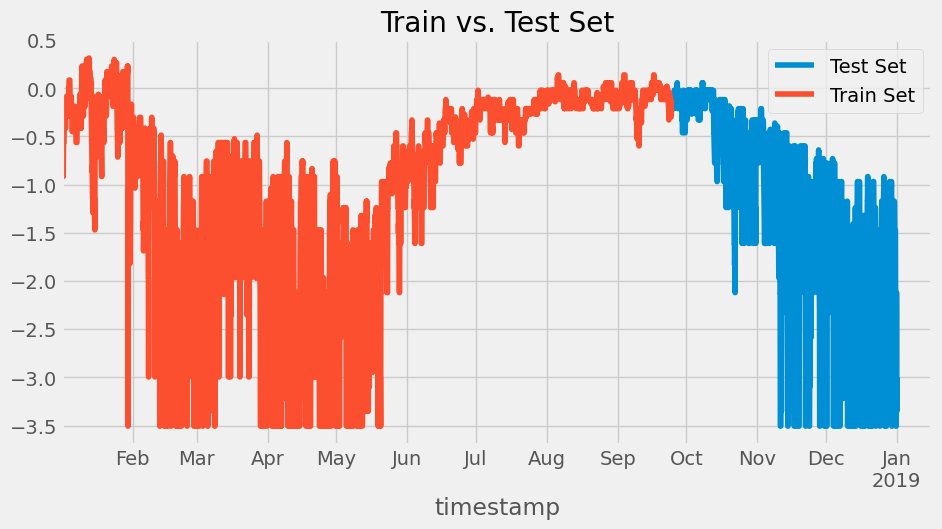

In [11]:
# calculate the split based on percentage
total_rows = len(df)
split_index = int(total_rows * 0.7)  # 70% of the data
split_date = df.index[split_index]

#split_date = 2018-01-01 # enter data manually

train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

test.rename(columns = {'y': 'Test Set'}).join(train.rename(columns = {'y': 'Train Set'}), how = 'outer')\
.plot(figsize = (10,5), title = 'Train vs. Test Set')
plt.show()

In [12]:
train_data = train.reset_index().rename(columns = {'timestamp':'ds'})
test_data = test.reset_index().rename(columns = {'timestamp': 'ds'})

In [13]:
train_data.tail()

,ds,y
6387,2018-09-24 08:00:00,-0.210721
6388,2018-09-24 09:00:00,-0.297732
6389,2018-09-24 10:00:00,-0.238892
6390,2018-09-24 11:00:00,-0.162519
6391,2018-09-24 12:00:00,-0.116534


In [14]:
test_data.head()

,ds,y
0,2018-09-24 13:00:00,-0.116534
1,2018-09-24 14:00:00,-0.116534
2,2018-09-24 15:00:00,-0.116534
3,2018-09-24 16:00:00,-0.116534
4,2018-09-24 17:00:00,-0.116534


In [15]:
m = Prophet(changepoint_prior_scale=0.011,yearly_seasonality=True,interval_width=0.95)
m.add_country_holidays(country_name='US')
m.fit(train_data)
test_forecast = m.predict(test_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/r557gt1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/895kk4ag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57024', 'data', 'file=/tmp/tmpsobbnafk/r557gt1v.json', 'init=/tmp/tmpsobbnafk/895kk4ag.json', 'output', 'file=/tmp/tmpsobbnafk/prophet_modeln73vqri5/prophet_model-20230823135604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:56:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-09-24 13:00:00,-0.685289,-1.140809,0.865688,-0.685289,-0.685289,0.0,0.0,0.0,0.0,...,0.047815,0.047815,0.047815,0.547906,0.547906,0.547906,0.0,0.0,0.0,-0.125311
1,2018-09-24 14:00:00,-0.685258,-1.260078,0.873578,-0.685258,-0.685258,0.0,0.0,0.0,0.0,...,0.035179,0.035179,0.035179,0.547426,0.547426,0.547426,0.0,0.0,0.0,-0.178746
2,2018-09-24 15:00:00,-0.685227,-1.187501,0.690944,-0.685227,-0.685227,0.0,0.0,0.0,0.0,...,0.022710,0.022710,0.022710,0.546945,0.546945,0.546945,0.0,0.0,0.0,-0.231844
3,2018-09-24 16:00:00,-0.685195,-1.249926,0.733056,-0.685195,-0.685195,0.0,0.0,0.0,0.0,...,0.010511,0.010511,0.010511,0.546464,0.546464,0.546464,0.0,0.0,0.0,-0.275594
4,2018-09-24 17:00:00,-0.685164,-1.311842,0.715105,-0.685164,-0.685164,0.0,0.0,0.0,0.0,...,-0.001324,-0.001324,-0.001324,0.545984,0.545984,0.545984,0.0,0.0,0.0,-0.301634


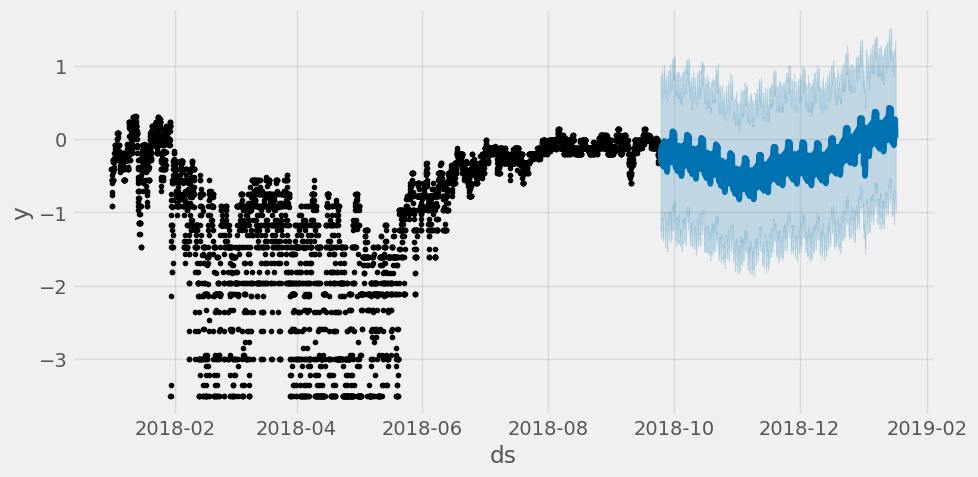

In [17]:
fig, ax = plt.subplots(figsize = (10,5))
fig = m.plot(test_forecast, ax = ax)
ax.set_title = ('Forecast')
plt.show()

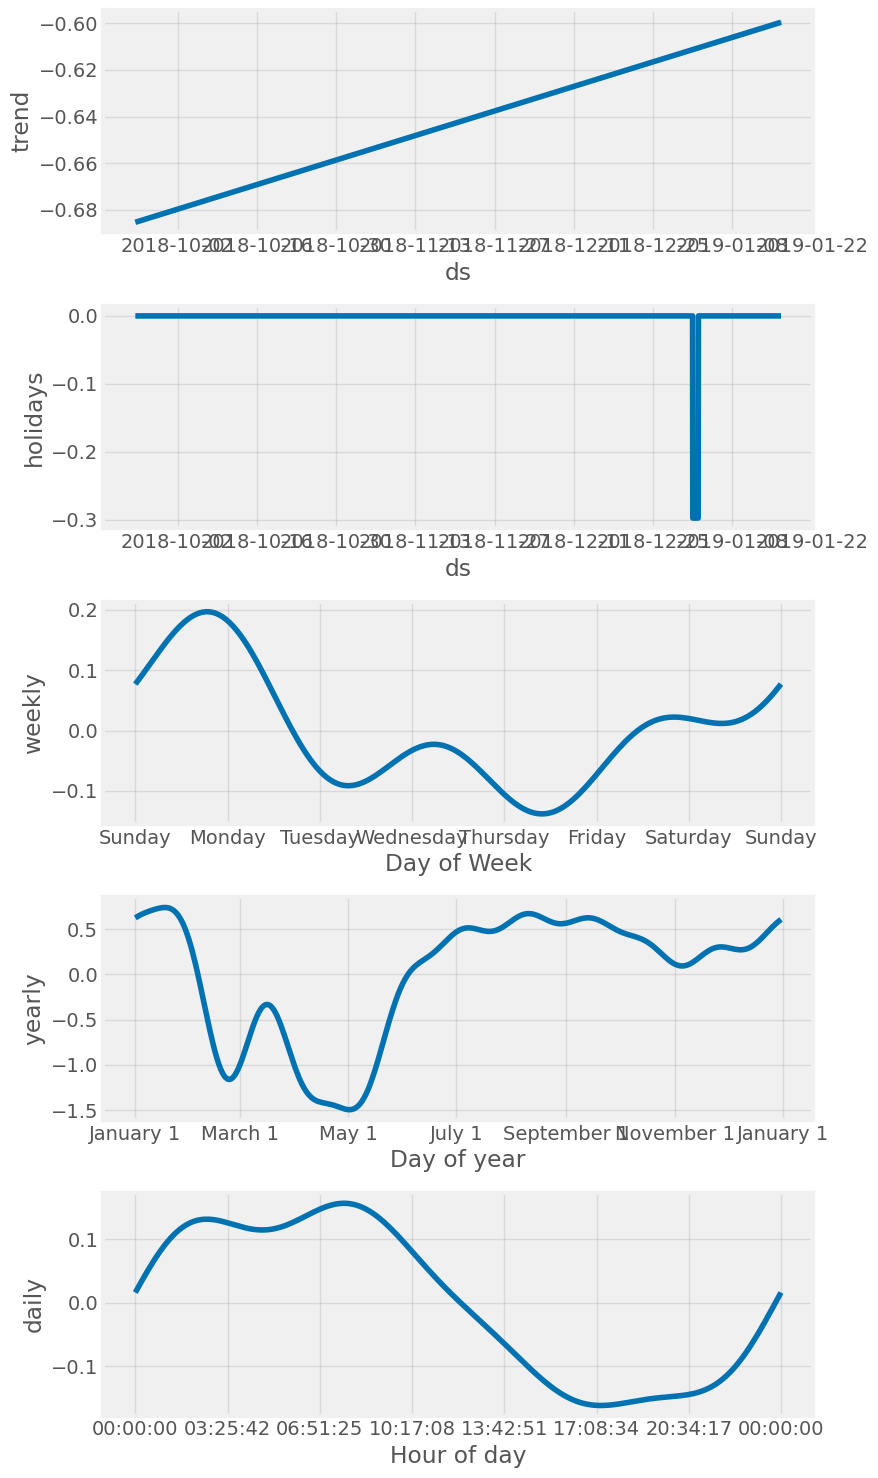

In [18]:
fig = m.plot_components(test_forecast)
plt.show()

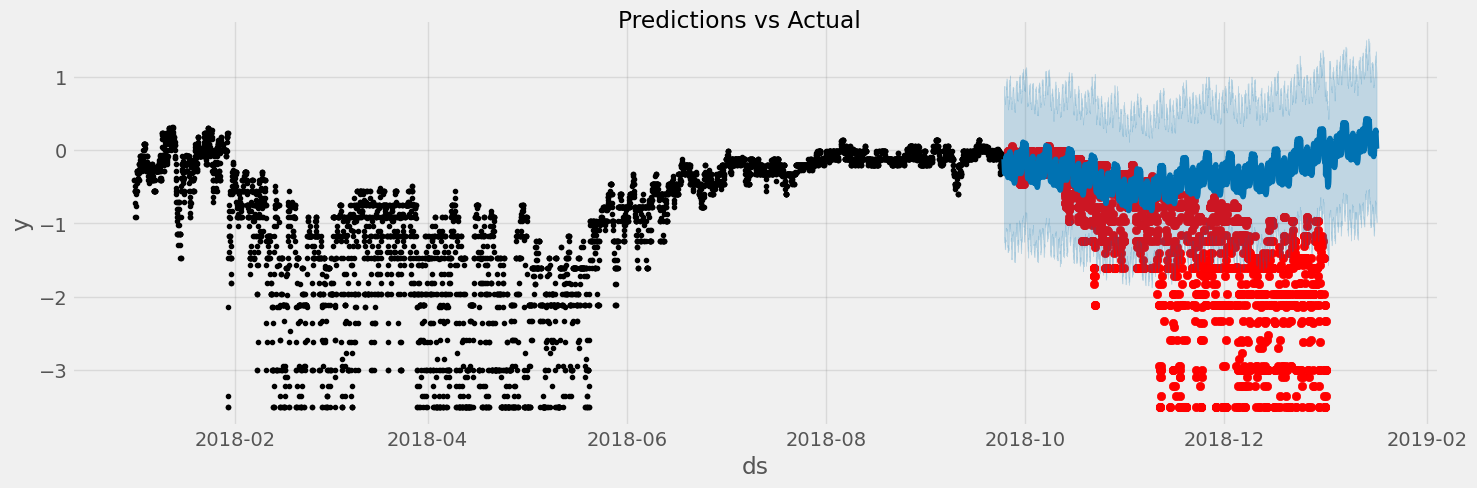

In [19]:
fig, ax = plt.subplots(figsize = (15,5))
ax.scatter(test.index, test['y'], color = 'r')
fig = m.plot(test_forecast, ax=ax)
plot = plt.suptitle('Predictions vs Actual')

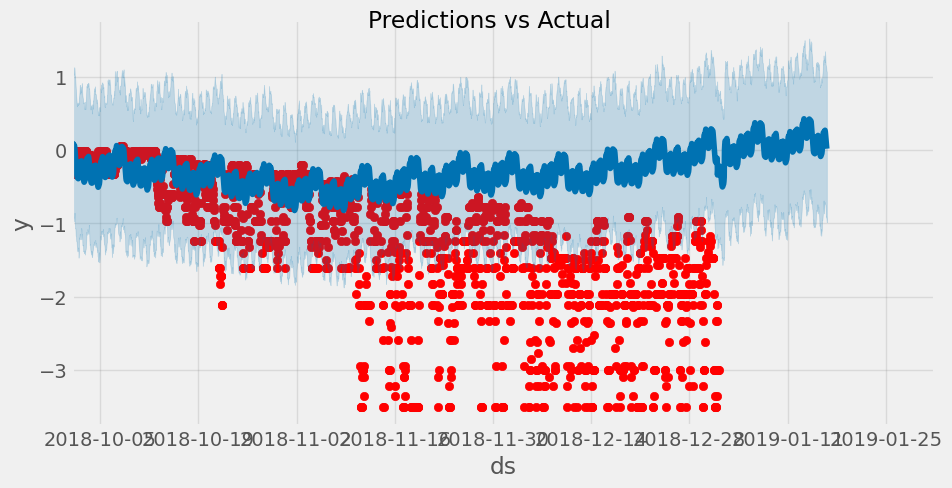

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['y'], color='r')
fig = m.plot(test_forecast, ax=ax)
ax.set_xlim(pd.Timestamp('2018-10-01'), pd.Timestamp('2019-02-01'))
plot = plt.suptitle('Predictions vs Actual')

In [120]:
data = pd.read_csv('/content/drive/MyDrive/394_points.csv',
                   usecols=['timestamp','Tenant Plant Chiller 1 Ch1kW (Unit: kW)'],
                   index_col=[0], parse_dates=[0])
data

,Tenant Plant Chiller 1 Ch1kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,NaN
2018-01-01 06:00:00,NaN
2018-01-01 07:00:00,NaN
2018-01-01 08:00:00,NaN
2018-01-01 09:00:00,NaN
...,...
2019-01-16 10:00:00,NaN
2019-01-16 11:00:00,NaN
2019-01-16 12:00:00,NaN


In [121]:
data = data['Tenant Plant Chiller 1 Ch1kW (Unit: kW)'].dropna()
data

timestamp
2018-02-22 22:00:00    43.4400
2018-02-22 23:00:00    14.5300
2018-02-23 00:00:00    42.9875
2018-02-23 01:00:00    10.4825
2018-02-23 02:00:00    43.0100
                        ...   
2019-01-01 00:00:00    27.5375
2019-01-01 01:00:00    27.8125
2019-01-01 02:00:00    27.5925
2019-01-01 03:00:00    27.7025
2019-01-01 04:00:00    27.6300
Name: Tenant Plant Chiller 1 Ch1kW (Unit: kW), Length: 7495, dtype: float64

In [122]:
oat = pd.read_csv('/content/drive/MyDrive/oat_data.csv',
                   usecols=['date','Air Temp ˚F'],
                   index_col=[0], parse_dates=[0])
oat.index.name = 'timestamp'

In [123]:
oat = oat[oat['Air Temp ˚F'] != 'M']

In [124]:
merge = pd.merge(data, oat, on='timestamp', how='inner')

In [125]:
merge = merge.rename(columns={merge.columns[0]:'y'})
merge.head()

,y,Air Temp ˚F
timestamp,,
2018-02-23 02:00:00,43.0100,37
2018-02-23 03:00:00,10.7425,36
2018-02-23 04:00:00,43.2325,36
2018-02-23 05:00:00,0.0000,36
2018-02-23 06:00:00,43.2550,36


In [126]:
merge['Air Temp ˚F'] = pd.to_numeric(merge['Air Temp ˚F'], errors='coerce')
small_constant = 1e-8
merge['y'] = np.log(merge['y'] + small_constant)
merge['Air Temp ˚F'] = np.log(merge['Air Temp ˚F'] + small_constant)
merge.head()

,y,Air Temp ˚F
timestamp,,
2018-02-23 02:00:00,3.761433,3.610918
2018-02-23 03:00:00,2.374208,3.583519
2018-02-23 04:00:00,3.766593,3.583519
2018-02-23 05:00:00,-18.420681,3.583519
2018-02-23 06:00:00,3.767113,3.583519


In [127]:
# calculate the split based on percentage
total_rows = len(merge)
split_index = int(total_rows * 0.7)  # 70% of the data
split_date = merge.index[split_index]

#split_date = 2018-01-01 # enter data manually

train = merge.loc[merge.index <= split_date].copy()
test = merge.loc[merge.index > split_date].copy()

In [128]:
train_data = train.reset_index().rename(columns = {'timestamp':'ds'})
test_data = test.reset_index().rename(columns = {'timestamp': 'ds'})

In [132]:
m = Prophet(changepoint_prior_scale=0.011,yearly_seasonality=True,interval_width=0.95)
m.add_country_holidays(country_name='US')
m.fit(train_data)
test_forecast = m.predict(test_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/hsk7wh56.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/r00pccqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69494', 'data', 'file=/tmp/tmpsobbnafk/hsk7wh56.json', 'init=/tmp/tmpsobbnafk/r00pccqi.json', 'output', 'file=/tmp/tmpsobbnafk/prophet_model50rr7ndh/prophet_model-20230823155148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:51:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:51:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


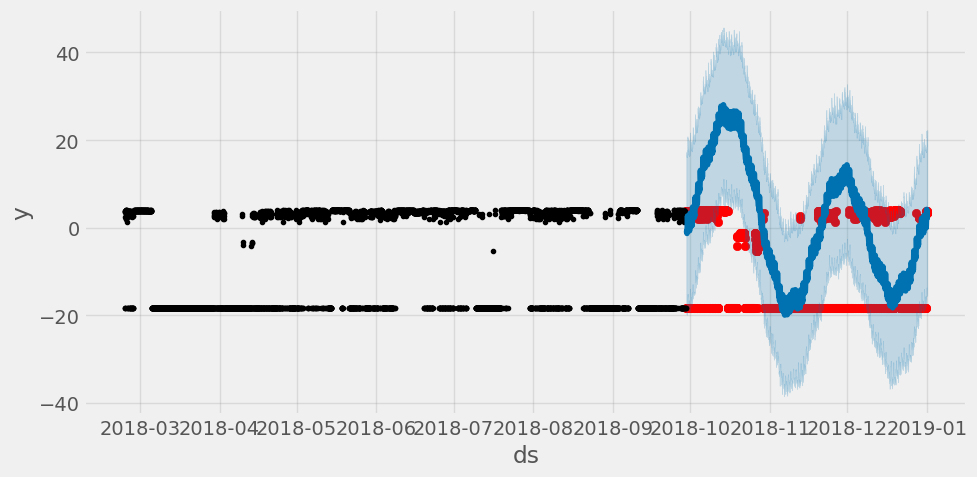

In [133]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['y'], color='r')
fig = m.plot(test_forecast, ax=ax)

In [129]:
m = Prophet(changepoint_prior_scale=0.011,yearly_seasonality=True,interval_width=0.95)
m.add_country_holidays(country_name='US')
m.add_regressor('Air Temp ˚F')
m.fit(train_data)
test_forecast = m.predict(test_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/xyrwuv4o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/3hqvvu9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30043', 'data', 'file=/tmp/tmpsobbnafk/xyrwuv4o.json', 'init=/tmp/tmpsobbnafk/3hqvvu9x.json', 'output', 'file=/tmp/tmpsobbnafk/prophet_modelj23_pn57/prophet_model-20230823155059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:50:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:51:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


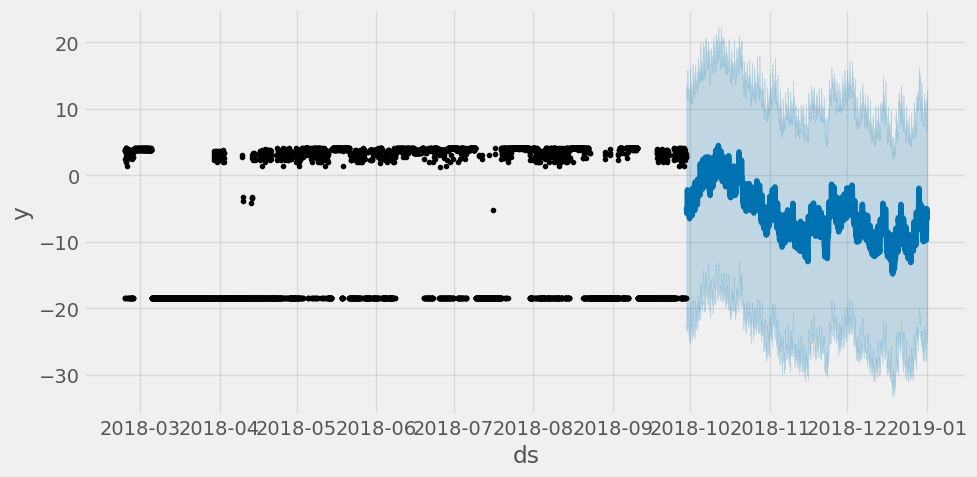

In [130]:
fig, ax = plt.subplots(figsize = (10,5))
fig = m.plot(test_forecast, ax = ax)
ax.set_title = ('Forecast')
plt.show()

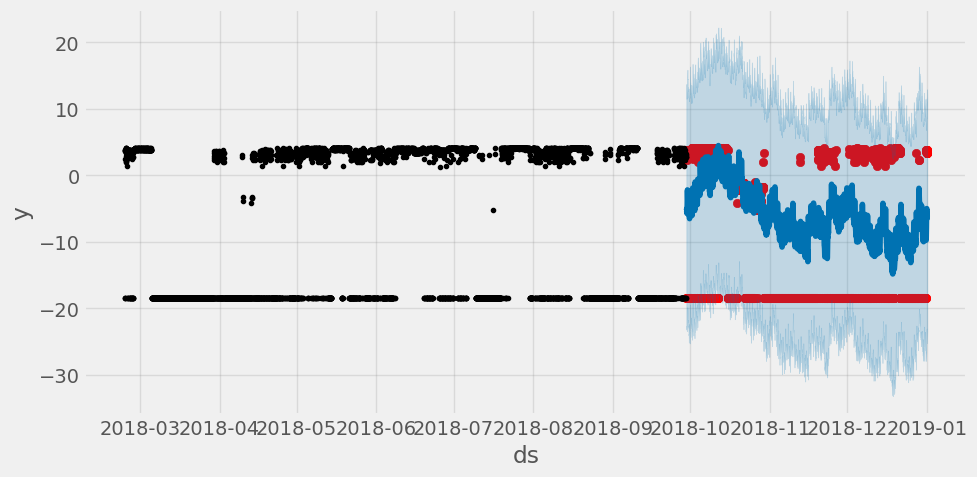

In [131]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['y'], color='r')
fig = m.plot(test_forecast, ax=ax)

In [162]:
df = pd.read_csv('/content/drive/MyDrive/394_points.csv', usecols=[0,11], index_col=[0], parse_dates=[0])
df.head()

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570


In [163]:
df = df.rename(columns={df.columns[0]:'y'})
df = df['y'].dropna()
merge = pd.merge(df, oat, on='timestamp', how='inner')
merge = pd.DataFrame(merge)
merge['Air Temp ˚F'] = pd.to_numeric(merge['Air Temp ˚F'], errors='coerce')
small_constant = 1e-8
merge['y'] = np.log(merge['y'] + small_constant)
merge['Air Temp ˚F'] = np.log(merge['Air Temp ˚F'] + small_constant)
merge.head()

,y,Air Temp ˚F
timestamp,,
2018-02-22 00:00:00,-1.966113,4.077537
2018-02-22 01:00:00,-1.966113,4.060443
2018-02-22 02:00:00,-2.120263,4.025352
2018-02-22 03:00:00,-2.120263,3.970292
2018-02-22 04:00:00,-2.120263,3.912023


In [167]:
# calculate the split based on percentage
total_rows = len(merge)
split_index = int(total_rows * 0.7)  # 70% of the data
split_date = merge.index[split_index]

#split_date = 2018-01-01 # enter data manually

train = merge.loc[merge.index <= split_date].copy()
test = merge.loc[merge.index > split_date].copy()

In [168]:
train_data = train.reset_index().rename(columns = {'timestamp':'ds'})
test_data = test.reset_index().rename(columns = {'timestamp': 'ds'})

In [172]:
test_data.tail()

,ds,y,Air Temp ˚F
2247,2019-01-01 00:00:00,-3.352407,3.850148
2248,2019-01-01 01:00:00,-2.995732,3.850148
2249,2019-01-01 02:00:00,-2.995732,3.912023
2250,2019-01-01 03:00:00,-2.995732,3.951244
2251,2019-01-01 04:00:00,-2.995732,3.931826


In [169]:
m = Prophet(changepoint_prior_scale=0.011,yearly_seasonality=True,interval_width=0.95)
m.add_country_holidays(country_name='US')
m.add_regressor('Air Temp ˚F')
m.fit(train_data)
test_forecast = m.predict(test_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/4owxn5k6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/vxty9nhj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47476', 'data', 'file=/tmp/tmpsobbnafk/4owxn5k6.json', 'init=/tmp/tmpsobbnafk/vxty9nhj.json', 'output', 'file=/tmp/tmpsobbnafk/prophet_model_olnpg9f/prophet_model-20230823160402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:04:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:04:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


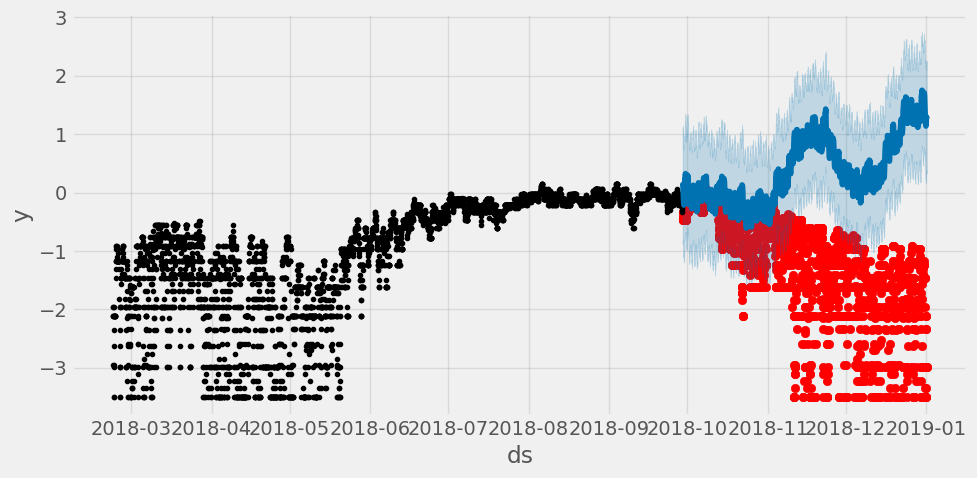

In [170]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['y'], color='r')
fig = m.plot(test_forecast, ax=ax)

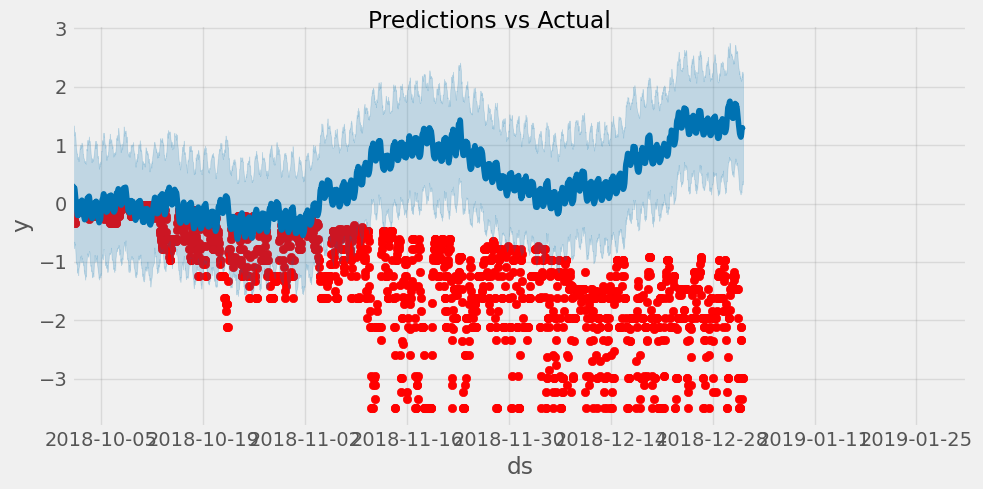

In [171]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['y'], color='r')
fig = m.plot(test_forecast, ax=ax)
ax.set_xlim(pd.Timestamp('2018-10-01'), pd.Timestamp('2019-02-01'))
plot = plt.suptitle('Predictions vs Actual')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/5esgl1ii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsobbnafk/a58yn76b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95273', 'data', 'file=/tmp/tmpsobbnafk/5esgl1ii.json', 'init=/tmp/tmpsobbnafk/a58yn76b.json', 'output', 'file=/tmp/tmpsobbnafk/prophet_model1tffvyx9/prophet_model-20230823171903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


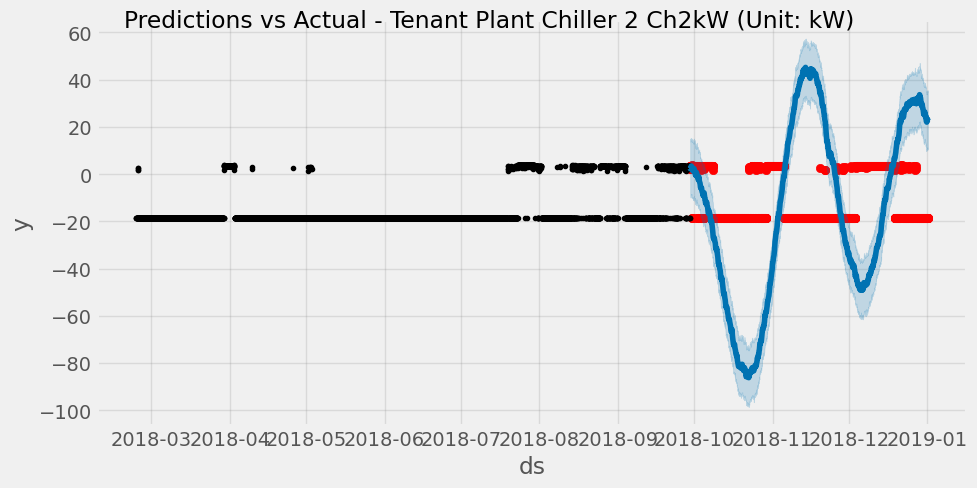

In [193]:
def automate_prophet(csv_path, csv_col, oat_path, oat_col, train_ratio=0.7, changepoint_prior_scale=0.011):
    # Read the data and process
    data = pd.read_csv(csv_path, usecols=[0, csv_col], index_col=[0], parse_dates=[0])
    value_column = data.columns[0]
    data = data[value_column].dropna()

    oat = pd.read_csv(oat_path, usecols=[0, oat_col], index_col=[0], parse_dates=[0])
    oat.index.name = 'timestamp'
    oat_column = oat.columns[0]
    oat = oat[oat[oat_column] != 'M']

    merge = pd.merge(data, oat, on='timestamp', how='inner')
    merge = merge.rename(columns={merge.columns[0]: 'y'})

    small_constant = 1e-8
    merge['y'] = np.log(merge['y'] + small_constant)
    merge[oat_column] = pd.to_numeric(merge[oat_column], errors='coerce')
    merge[oat_column] = np.log(merge[oat_column] + small_constant)

    # Split data
    total_rows = len(merge)
    split_index = int(total_rows * train_ratio)
    split_date = merge.index[split_index]

    train = merge.loc[merge.index <= split_date].copy()
    test = merge.loc[merge.index > split_date].copy()
    train_data = train.reset_index().rename(columns={'timestamp': 'ds'})
    test_data = test.reset_index().rename(columns={'timestamp': 'ds'})

    # Prophet modeling
    m = Prophet(changepoint_prior_scale=changepoint_prior_scale, yearly_seasonality=True, interval_width=0.95)
    m.add_country_holidays(country_name='US')
    m.add_regressor(oat_column)
    m.fit(train_data)

    # Predict
    test_forecast = m.predict(test_data)

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(test.index, test['y'], color='r')
    fig = m.plot(test_forecast, ax=ax)
    plot_title = f'Predictions vs Actual - {value_column}'
    plt.suptitle(plot_title)
    plt.show()

# testing
csv_path = '/content/drive/MyDrive/394_points.csv'
csv_col = 15  #9
oat_path = '/content/drive/MyDrive/oat_data.csv'
oat_col = 1

automate_prophet(csv_path, csv_col, oat_path, oat_col)


# **skforecast predictions**

In [21]:
data = pd.read_csv('/content/drive/MyDrive/394_points.csv', usecols=[0,11])
data.head()

,timestamp,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
0,2018-01-01 05:00:00,0.660
1,2018-01-01 06:00:00,0.660
2,2018-01-01 07:00:00,0.615
3,2018-01-01 08:00:00,0.570
4,2018-01-01 09:00:00,0.570


In [22]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   timestamp                                               8760 non-null   object 
 1   House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)  8760 non-null   float64
dtypes: float64(1), object(1)
memory usage: 205.3+ KB


In [23]:
data = data.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('timestamp')
data = data.asfreq('1H')
data = data.sort_index()
data.head(2)

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.66
2018-01-01 06:00:00,0.66


In [24]:
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

True

In [25]:
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


In [26]:
data.asfreq(freq='1H', fill_value=np.nan)

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570
...,...
2019-01-01 00:00:00,0.035
2019-01-01 01:00:00,0.050
2019-01-01 02:00:00,0.050


In [27]:
total_rows = len(data)
train_percent = 0.7

train_index = int(total_rows * train_percent)

train_date = data.index[train_index]

train = data.loc[data.index <= train_date].copy()
test = data.loc[data.index > train_date].copy()

In [28]:
print(f"Train dates      : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates       : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Train dates      : 2018-01-01 05:00:00 --- 2018-09-13 17:00:00  (n=6133)
Test dates       : 2018-09-13 18:00:00 --- 2019-01-01 04:00:00  (n=2627)


In [29]:
col = 'House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)'

In [30]:
max = pd.to_datetime(test.index.max())
max

Timestamp('2019-01-01 04:00:00', freq='H')

In [31]:
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data.loc[:test.index.max(), col])
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2018-01-01 05:00:00'), Timestamp('2019-01-01 04:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-08-23 13:56:16 
Last fit date: 2023-08-23 13:56:16 
Skforecast version: 0.9.1 
Python version: 3.10.12 
Forecaster id: None 

In [32]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data[col],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:train.index.max()]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                    )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 6133
Number of observations used for backtesting: 2627
    Number of folds: 110
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 11 observations.

Fold: 0
    Training:   2018-01-01 05:00:00 -- 2018-09-13 17:00:00  (n=6133)
    Validation: 2018-09-13 18:00:00 -- 2018-09-14 17:00:00  (n=24)
Fold: 1
    Training:   2018-01-01 05:00:00 -- 2018-09-13 17:00:00  (n=6133)
    Validation: 2018-09-14 18:00:00 -- 2018-09-15 17:00:00  (n=24)
Fold: 2
    Training:   2018-01-01 05:00:00 -- 2018-09-13 17:00:00  (n=6133)
    Validation: 2018-09-15 18:00:00 -- 2018-09-16 17:00:00  (n=24)
Fold: 3
    Training:   2018-01-01 05:00:00 -- 2018-09-13 17:00:00  (n=6133)
    Validation: 2018-09-16 18:00:00 -- 2018-09-17 17:00:00  (n=24)
Fold: 4
    Training:   2018-01-01 05:00:00 -- 2018-09-13 17:0

  0%|          | 0/110 [00:00<?, ?it/s]

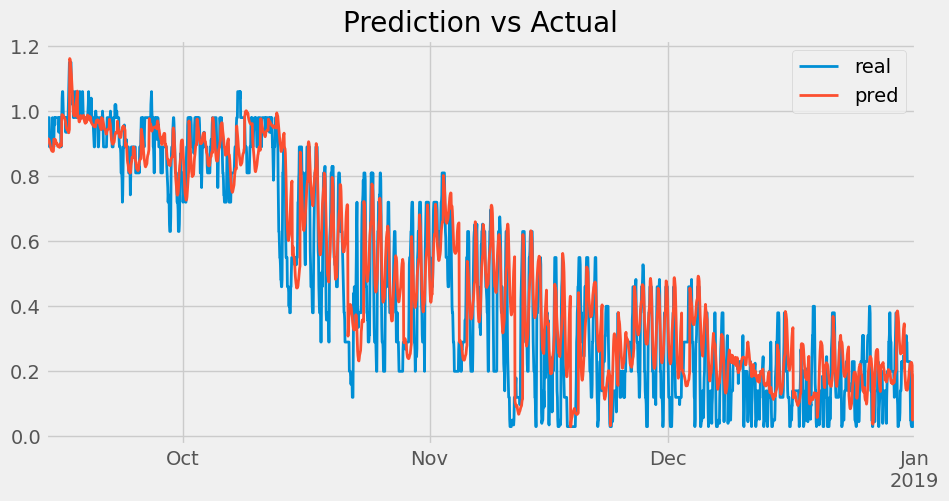

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
data.loc[predictions.index, col].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Actual')
ax.legend();

In [34]:
print(f'Backtest error: {metric}')

Backtest error: 0.10033813062521856


In [35]:
lags = 24
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = lags,
                 transformer_y = StandardScaler()
             )


lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]


param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:test.index.max(), col],
                   steps              = 24,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   initial_train_size = len(data[:train.index.max()]),
                   refit              = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 0.46415888336127775}
  Backtesting metric: 0.09947528161698292



  0%|          | 0/110 [00:00<?, ?it/s]

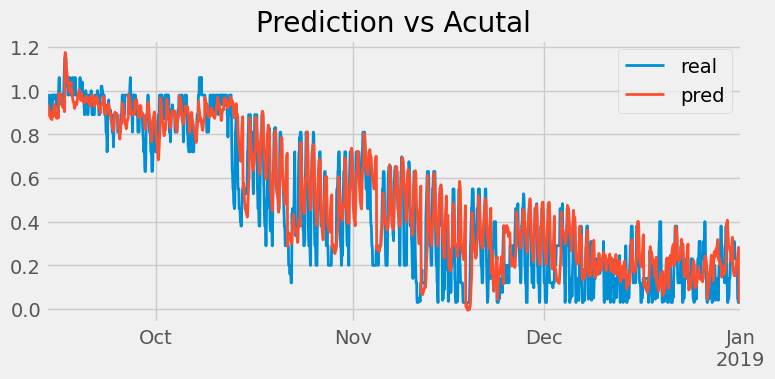

In [36]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data[col],
                          steps              = 24,
                          metric             = mean_absolute_error,
                          initial_train_size = len(data[:train.index.max()]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, col].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Acutal')
ax.legend();

In [37]:
print(f'Backtest error: {metric}')

Backtest error: 0.09947528161698292


In [38]:
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data[col],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:train.index.max()]),
                          refit               = False,
                          interval            = [10, 90],
                          n_boot              = 500,
                          in_sample_residuals = True,
                          n_jobs             = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )

print('Backtesting metric:', metric)

  0%|          | 0/110 [00:00<?, ?it/s]

Backtesting metric: 0.09947528161698292


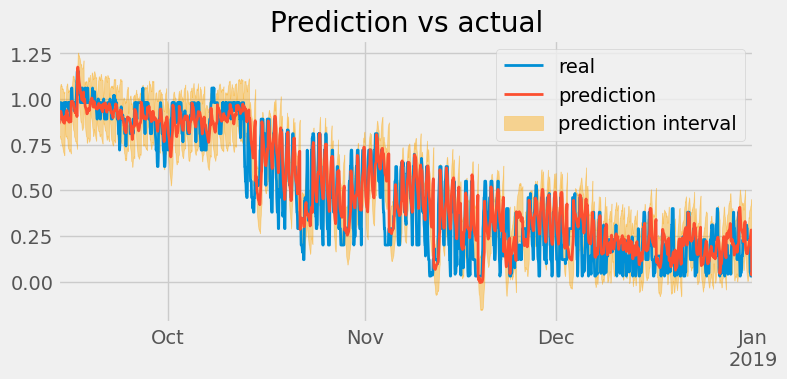

In [39]:
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, col].plot(linewidth=2, label='real', ax=ax)
predictions.iloc[:, 0].plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs actual')
ax.fill_between(
    predictions.index,
    predictions.iloc[:, 1],
    predictions.iloc[:, 2],
    alpha = 0.4,
    color = 'orange',
    label = 'prediction interval'
)
ax.legend();

  0%|          | 0/363 [00:00<?, ?it/s]

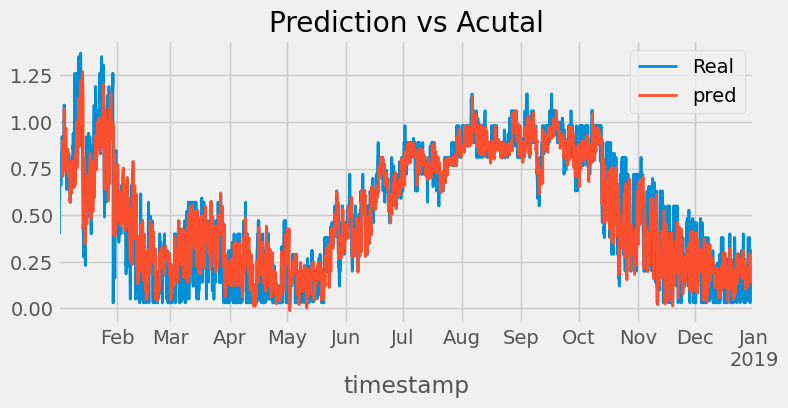

In [40]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data[col],
                          steps              = 24,
                          metric             = mean_absolute_error,
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(8, 3.5))
data[col].plot(linewidth=2, label='Real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Acutal')
ax.legend();